In [1]:
# To use TF 2.0 (on EC2 instance running Deep Learning AMI):
# source activate tensorflow_p36
# pip uninstall tensorflow-gpu
# pip install tensorflow-gpu==2.0.0-alpha0

# But then later decided wanted even newer GPU stuff and "in that conda env, ran:
# pip uninstall tensorflow-gpu
# pip install --upgrade pip
# pip install wrapt --ignore-installed # ran this because had an error
# pip install  tf-nightly-gpu-2.0-preview

# Result: Successfully installed tf-nightly-gpu-2.0-preview-2.0.0.dev20190601

In [2]:
import os
from datetime import datetime
import numpy as np
import tensorflow as tf

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn') # pretty matplotlib plots
plt.rcParams["axes.grid"] = False # don't show grid lines on plots by default
plt.rcParams['figure.figsize'] = (12, 16) # increase size of subplots

In [4]:
from packaging import version

print("TensorFlow version: ", tf.__version__) # make sure >= 2.0.0-dev20190601
assert version.parse(tf.__version__).release[0] >= 2, "This notebook requires TensorFlow 2.0 or above."


TensorFlow version:  2.0.0-dev20190601


In [5]:
import cs230_project_utilities as utils

In [6]:
# GPU usage logging (TF 2.0+)

tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(False)

# Data

# Convert dataset to TFRecords

In [7]:
# Location of .h5 files
raw_data_locations = ['/home/ubuntu/cs230/data/fastmri/raw/singlecoil_test/*.h5']
test_tfrecord_directory = '/home/ubuntu/cs230/data/fastmri/tfrecords/singlecoil_test'
tfrecord_locations = '/home/ubuntu/cs230/data/fastmri/tfrecords/singlecoil_test/*.tfrecord'

In [8]:
utils.fastmri.convert_fastmri_dataset_to_tfrecord_files(raw_data_locations, test_tfrecord_directory, include_reconstruction=False)

Converting file 0 at b'/home/ubuntu/cs230/data/fastmri/raw/singlecoil_test/file1002167.h5' to TFRecords...
Converting file 1 at b'/home/ubuntu/cs230/data/fastmri/raw/singlecoil_test/file1002527.h5' to TFRecords...
Converting file 2 at b'/home/ubuntu/cs230/data/fastmri/raw/singlecoil_test/file1002091.h5' to TFRecords...
Converting file 3 at b'/home/ubuntu/cs230/data/fastmri/raw/singlecoil_test/file1002452.h5' to TFRecords...
Converting file 4 at b'/home/ubuntu/cs230/data/fastmri/raw/singlecoil_test/file1002116.h5' to TFRecords...
Converting file 5 at b'/home/ubuntu/cs230/data/fastmri/raw/singlecoil_test/file1002480.h5' to TFRecords...
Converting file 6 at b'/home/ubuntu/cs230/data/fastmri/raw/singlecoil_test/file1000056.h5' to TFRecords...
Converting file 7 at b'/home/ubuntu/cs230/data/fastmri/raw/singlecoil_test/file1001859.h5' to TFRecords...
Converting file 8 at b'/home/ubuntu/cs230/data/fastmri/raw/singlecoil_test/file1001670.h5' to TFRecords...
Converting file 9 at b'/home/ubuntu/c

Converting file 76 at b'/home/ubuntu/cs230/data/fastmri/raw/singlecoil_test/file1001400.h5' to TFRecords...
Converting file 77 at b'/home/ubuntu/cs230/data/fastmri/raw/singlecoil_test/file1000937.h5' to TFRecords...
Converting file 78 at b'/home/ubuntu/cs230/data/fastmri/raw/singlecoil_test/file1001135.h5' to TFRecords...
Converting file 79 at b'/home/ubuntu/cs230/data/fastmri/raw/singlecoil_test/file1001657.h5' to TFRecords...
Converting file 80 at b'/home/ubuntu/cs230/data/fastmri/raw/singlecoil_test/file1002384.h5' to TFRecords...
Converting file 81 at b'/home/ubuntu/cs230/data/fastmri/raw/singlecoil_test/file1001483.h5' to TFRecords...
Converting file 82 at b'/home/ubuntu/cs230/data/fastmri/raw/singlecoil_test/file1001418.h5' to TFRecords...
Converting file 83 at b'/home/ubuntu/cs230/data/fastmri/raw/singlecoil_test/file1001443.h5' to TFRecords...
Converting file 84 at b'/home/ubuntu/cs230/data/fastmri/raw/singlecoil_test/file1000950.h5' to TFRecords...
Converting file 85 at b'/hom

In [9]:
ll -h $test_tfrecord_directory

total 6.9G
-rw-rw-r-- 1 ubuntu 929M Jun  3 10:24 shard-0.tfrecord
-rw-rw-r-- 1 ubuntu 955M Jun  3 10:24 shard-1.tfrecord
-rw-rw-r-- 1 ubuntu 908M Jun  3 10:25 shard-2.tfrecord
-rw-rw-r-- 1 ubuntu 926M Jun  3 10:25 shard-3.tfrecord
-rw-rw-r-- 1 ubuntu 916M Jun  3 10:25 shard-4.tfrecord
-rw-rw-r-- 1 ubuntu 912M Jun  3 10:25 shard-5.tfrecord
-rw-rw-r-- 1 ubuntu 934M Jun  3 10:25 shard-6.tfrecord
-rw-rw-r-- 1 ubuntu 576M Jun  3 10:26 shard-7.tfrecord


In [10]:
# rm -r $test_tfrecord_directory

## Load dataset as TFRecords 
See dataset exploration notebook for visuals of the data.

In [104]:
# Use tf.data.Datasets to preprocess and iterate data efficiently

# include class_0?
test_data_locations = dev_data_locations = train_data_locations = [test_tfrecord_directory]

# Create preprocessing functions

preprocessing_fn = utils.fastmri.fastMRIPreprocessor(shape=(128, 128),
                                                     use_tiled_reflections=False,
                                                     subsampling_mask_function=None,
                                                     normalize=True,
                                                     include_reconstruction=True)

batch_size = 2
shuffle_buffer_size = 1

# Load data

test_dataset = utils.fastmri.load_dataset(tfrecord_locations,
                                     batch_size=batch_size,
                                     shuffle_buffer_size=shuffle_buffer_size,
                                     include_reconstruction=True,
                                     recreate_reconstruction=True,
                                     include_all_parsed_features=False,
                                     ignore_errors=False,
                                     preprocessing_function=preprocessing_fn)

# dev_dataset = utils.fastmri.load_dataset(dev_data_locations,
#                                      batch_size=batch_size,
#                                      shuffle_buffer_size=shuffle_buffer_size,
#                                      include_all_parsed_features=True,
#                                      ignore_errors=True,
#                                      preprocessing_function=preprocessing_fn)

# train_dataset = utils.fastmri.load_dataset(train_data_locations,
#                                      batch_size=batch_size,
#                                      shuffle_buffer_size=shuffle_buffer_size,
#                                      include_all_parsed_features=False,
#                                      ignore_errors=True,
#                                      preprocessing_function=preprocessing_fn)


# Debugging: make these datasets tiny

# test_dataset = test_dataset
# dev_dataset = dev_dataset.take(3)
# train_dataset = train_dataset.take(3)

Loading dataset... Shuffle items? True. Shuffle buffer: 1


In [105]:
# First batch of each dataset to be used in plotting images periodically to tensorboard

first_test_batch = next(iter(test_dataset))
# first_dev_batch = next(iter(dev_dataset))
# first_train_batch = next(iter(train_dataset))

In [106]:
first_test_batch[1].shape

TensorShape([2, 128, 128, 1])

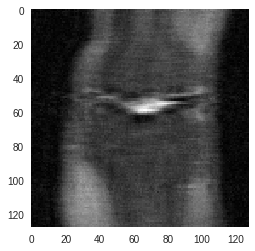

--------


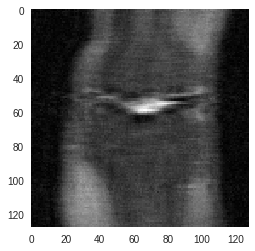

In [107]:
img = first_test_batch[1][0]
fftimg = tf.abs(utils.signal_processing.tf_ifft2d(utils.signal_processing.tf_fft2d(img))).numpy().squeeze()
utils.plot.imshowgray(fftimg)
plt.show()
print('--------')
utils.plot.imshowgray(img.numpy().squeeze())

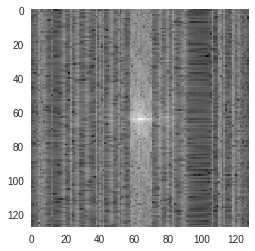

In [108]:
fft = utils.fastmri.combine_two_channels_of_complex_tensor(first_test_batch[0][0]).numpy()

utils.plot.imshowfft(fft)

In [109]:
fftimg = tf.abs(utils.signal_processing.tf_ifft2d(fft)).numpy().squeeze()

In [110]:
np.allclose(first_test_batch[1][0], fftimg, atol=1e-3)

False

In [111]:
utils.signal_processing.mean_square_error(
    tf.abs(utils.signal_processing.tf_ifft2d(
        utils.fastmri.combine_two_channels_of_complex_tensor(
            first_test_batch[0][0]))).numpy().squeeze(),
    img.numpy())

0.039028157

In [112]:
first_test_batch[0].shape

TensorShape([2, 128, 128, 2])

# Model

In [20]:
# A metric to use during training
def mean_PSNR(y_true, y_pred):
    max_value = 1.0
    MSE = tf.reduce_mean(tf.square(y_true - y_pred), axis=[1, 2, 3])
    PSNR = 10 * tf.math.log(tf.divide(max_value ** 2, MSE)) / tf.math.log(tf.constant(10, dtype=y_pred.dtype))
    mean = tf.reduce_mean(PSNR)
    return mean

In [21]:
def load_uncompiled_automap_model():

    N = 128
    X = tf.keras.layers.Input(shape=(N, N, 2))

    # Paper says 1% multiplicative gaussian noise (this multiplies by 1-centered gaussian
    # having stddev = sqrt(rate / (1 - rate)) (here, 0.00032...)
    # noisy_X = tf.keras.layers.GaussianDropout(rate=1e-7)(X) # spatial dimension: 256
    # Note: (we could corrupt when training with cifar, but maybe not other dataset?)

    ds_flat = tf.keras.layers.Flatten()(X)

    fc1 = tf.keras.layers.Dense(64 ** 2, activation='tanh')(ds_flat) # closer to original paper is: 128 ** 2
    fc1 = tf.keras.layers.Dropout(0.05)(fc1)
    fc2 = tf.keras.layers.Dense(128 ** 2, activation='tanh')(fc1)

    fc_output = tf.keras.layers.Reshape([128, 128, 1])(fc2)

    conv1 = tf.keras.layers.Conv2D(64, (5, 5), strides=(1, 1), activation='relu', padding='same')(fc_output)
    
    # L1 regularization to encourage sparsity
    conv2 = tf.keras.layers.Conv2D(64, (5, 5), strides=(1, 1), activation='relu', padding='same',
                                   activity_regularizer=tf.keras.regularizers.l1(1e-4))(conv1)

    Y_pred = tf.keras.layers.Conv2DTranspose(1, (7, 7), strides=1, activation='relu', padding='same')(conv2) # upsample to spatial dimension 256

    model = tf.keras.Model(inputs=X, outputs=Y_pred)

    return model

In [22]:
def load_compiled_automap_model():
    multi_gpu = False
    # Distribute training across GPUs (each GPU receives identical updates to weights but different batches w/
    # mirrored strategy). Restricts callbacks we can use
    if multi_gpu:
        mirrored_strategy = tf.distribute.MirroredStrategy()
        with mirrored_strategy.scope():
            model = load_uncompiled_automap_model()
            model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(), metrics=[mean_PSNR])
    else:
        model = load_uncompiled_automap_model()
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(), metrics=[mean_PSNR])
    return model

In [23]:
model = load_compiled_automap_model()

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 2)]     0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              134221824 
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 16384)             67125248  
_________________________________________________________________
reshape (Reshape)            (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      1664  

# Training

In [25]:
# Custom learning rate schedule


def lr_schedule(epoch):
    """
    Returns a custom learning rate that decreases as epochs progress.
    """
    if 0 <= epoch < 100:
        learning_rate = 1e-4
    elif 100 <= epoch < 200:
        learning_rate = 5e-5
    elif 200 <= epoch < 400:
        learning_rate = 2.55e-5
    elif 400 <= epoch < 600:
        learning_rate = 1e-5
    elif 600 <= epoch < 700:
        learning_rate = 2.5e-5
    elif 700 <= epoch < 800:
        learning_rate = 1e-5
    elif 800 <= epoch < 900:
        learning_rate = 1e-6
    else:
        learning_rate = 1e-7

    with file_writer.as_default():
        tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
        
    return learning_rate

# Show reconstructions during training

def plot_fft_reconstructions(batch, logs):
    plot_frequency = 2
    
    if batch % plot_frequency != 0:
        return
    
    batches = [(first_test_batch, 'Test')]#, (first_dev_batch, 'Dev'), (first_train_batch, 'Train')]
    
    for dataset_batch, name in batches:
        x, y = dataset_batch
        y = y.numpy()
        y_pred = model.predict(x)

        with file_writer.as_default():
            for i in range(min(len(y), 8)):
                prediction, ground_truth = y_pred[i:i + 1, ...], y[i:i + 1, ...]
                tf.summary.image("{} Image {} (Prediction)".format(name, i), prediction, max_outputs=1, step=batch)
                tf.summary.image("{} Image {} (Ground Truth)".format(name, i), ground_truth, max_outputs=1, step=batch)

In [26]:
# Clear logs if necessary
# !rm -r logs/

In [27]:
# Define where logs will be saved

logdir = os.path.join('logs', datetime.now().strftime("%Y-%m-%d_%H:%M:%S"))
file_writer = tf.summary.create_file_writer(os.path.join(logdir, 'metrics'))

### Callbacks to use in various stages of training

In [28]:
# Callback for printing the LR at the end of each epoch.

class PrintAndLogLR(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        with file_writer.as_default():
            tf.summary.scalar('learning rate (end of epoch)', data=model.optimizer.lr.numpy(), step=epoch)
        print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                          model.optimizer.lr.numpy()))

plot_images_callback = tf.keras.callbacks.LambdaCallback(on_batch_end=plot_fft_reconstructions)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, update_freq=1,
                                                      profile_batch=0) # workaround for: https://github.com/tensorflow/tensorboard/issues/2084

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.25,
                              patience=2, min_lr=1e-8)

callbacks = [tensorboard_callback, lr_callback, plot_images_callback, reduce_lr_callback, PrintAndLogLR()]

### Begin training and open Tensorboard to monitor

In [29]:
training_history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    verbose=1, # set to 0 to suppress chatty output and use Tensorboard instead
    epochs=2,
    callbacks=callbacks,
    use_multiprocessing=True) # see if speeds things up

NameError: name 'train_dataset' is not defined

### Save model (to do: make callback)

In [ ]:
# # # Uncomment to save model
# saved_model_path = 'automap_our_dataset_original_paper_model_with_up_down_sampling_single_GPU_small_FC_v6'
# model.save(saved_model_path)

## Evaluate model

In [ ]:
model.evaluate(test_dataset, verbose=1)
# model.evaluate(dev_dataset, verbose=1)
# model.evaluate(train_dataset, verbose=1)

### Plot training history (but better viewed in Tensorboard)

In [ ]:
plt.figure()
plt.plot(training_history.history["loss"], label="Train")
plt.plot(training_history.history["val_loss"], label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="center right")

In [ ]:
plt.figure()
plt.plot(training_history.history["mean_PSNR"], label="Train")
plt.plot(training_history.history["val_mean_PSNR"], label="Test")
plt.xlabel("Epoch")
plt.ylabel("µ ( PSNR ) ")
plt.legend(loc="center right")

In [ ]:
# Predict on a test batch

# batch = next(iter(test_dataset))

x, y = first_test_batch
x, y = x.numpy(), y.numpy()
y_pred = model.predict(x)

# Inspect output

for i in range(len(x)):

    fft_mag = x[i, ..., 0]
    fft_ang = x[i, ..., 1]
    reconstruction = y_pred[i, ..., 0]
    image = y[i, ..., 0]

    MSE = utils.signal_processing.mean_square_error(reconstruction, image)
    PSNR = utils.signal_processing.PSNR(reconstruction, image, max_value=max(image.max(), reconstruction.max()))

    plt.subplot(2, 2, 1)
    plt.title('Reconstruction (MSE: {:0.5f}, PSNR: {:0.5f})'.format(MSE, PSNR))
    utils.plot.imshowgray(reconstruction)

    plt.subplot(2, 2, 2)
    plt.title('FFT (Magnitude)')
    utils.plot.imshowfft(fft_mag)

    plt.subplot(2, 2, 3)
    plt.title('Expected reconstruction')
    utils.plot.imshowgray(image)

    plt.subplot(2, 2, 4)
    plt.title('FFT (Phase)')
    utils.plot.imshowgray(fft_ang)

    plt.show()
    break


In [ ]:
plt.imshow(y_pred[0].squeeze(), cmap='gray')

In [ ]:
plt.imshow(y[0].squeeze())